# Motif counts

This notebook will show you how to reproduce Figure 1 of 
[this paper](https://www.biorxiv.org/content/10.1101/2024.03.15.585196v2)
and understand the concepts behinds it.

To make this computationally easy, we will use only the C. elegans connectome.  At the end of this notebook there are some tips on how to deal with large graphs which are more computationally expensive. 

More precisely, the goal of this part of the tutorial is to be able to reproduce this figure for one single seed for each control. 
<center>
<img src="figs/Celegans_simplex_counts.png", width=500>
</center>

In particular, you will get to learn: 

* How to count (maximal) simplices of different types. 
* Understand the difference between maximal and non-maximal simplices.
* How to to count reciprocal connections in simplices.
* Some of the things these counts can and can't tell you.

More information on these and other topological analyses you can do on (unweigthed) directed networks can be found 
[here](https://github.com/danielaegassan/connectome_analysis/blob/master/tutorials/TDA_unweighted_networks.ipynb).


In [1]:
from connalysis.network import topology
from connalysis import randomization
import matplotlib.pyplot as plt

In [2]:
# Load the connectome (see the "Loading_the_data" notebook)
from helpers import read_connectomes
data_dir="data" # You chosen data directory 
# Loading Celegans connectome 
conn=read_connectomes.load_C_elegans_stages(data_dir).filter("type").eq("chemical").default(8)
conn.add_vertex_property('valid_cell', (topology.node_degree(conn.matrix)!=0)) 
conn=conn.index("valid_cell").isin(True)
adj=conn.matrix
adj.eliminate_zeros()

Warning!!! When accessing the adjacency as a sparse matrix using the .matrix property:
    Connections that are not present at a given stage, but at other stages will be represented as edges,
    but with a value of ``0`` synapses associated with them.  For structural analysis always use .eliminate_zeros


/gpfs/bbp.cscs.ch/home/egassant/basic_connalysis_tutorial/helpers/read_connectomes.py:174: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  edges_chem = syns_chem.index.to_frame().applymap(lambda x: nrn_idxx[x]).reset_index(drop=True)
/gpfs/bbp.cscs.ch/home/egassant/basic_connalysis_tutorial/helpers/read_connectomes.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  edges_elec = syns_elec.index.to_frame().applymap(lambda x: nrn_idxx[x]).reset_index(drop=True)


# Simplex counts

We can count (maximal) directed simplices in the connectome by simply doing

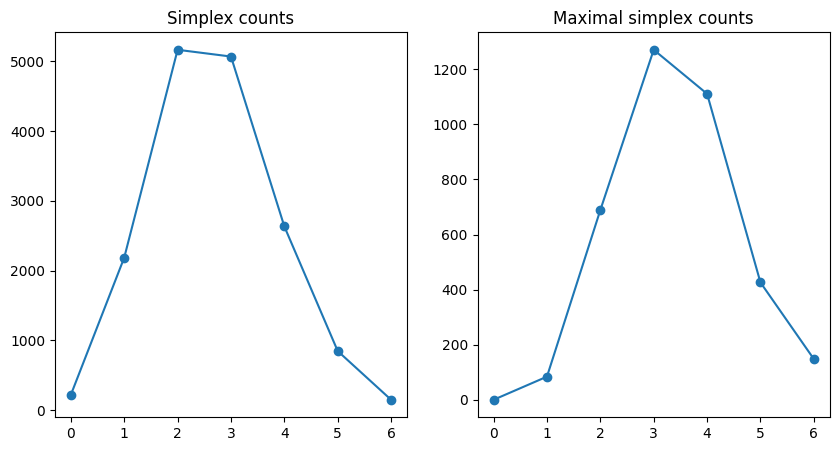

In [3]:
sc = topology.simplex_counts(adj, max_simplices=False,threads=8,max_dim=-1)
msc = topology.simplex_counts(adj, max_simplices=True,threads=8,max_dim=-1)
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].set_title("Simplex counts") 
axs[0].plot(sc.index, sc.values, label="all", marker = "o")
axs[1].set_title("Maximal simplex counts") 
axs[1].plot(msc.index, msc.values, label="all", marker = "o")

#### Questions: 

Take a minute to understand the difference between these two.  

* What are 0-simplices and 1-simplices equivalent to?
* What are maximal 0-simplices and 1-simplices equivalent to?

You can count other types of simplices with a different notion of direction by simply doing: 

In [4]:
print(f"Undirected simplex counts")
display(topology.simplex_counts(adj, max_simplices=False,threads=8,max_dim=-1, simplex_type='undirected'))
print(f"\nReciprocal simplex counts")
display(topology.simplex_counts(adj, max_simplices=False,threads=8,max_dim=-1, simplex_type='reciprocal'))


Undirected simplex counts


dim
0     219
1    1886
2    3175
3    1959
4     540
5      64
6       4
Name: simplex_count, dtype: int64


Reciprocal simplex counts


dim
0    219
1    300
2     83
3     10
Name: simplex_count, dtype: int64

#### Questions: 

Take a minute to understand the difference between these motif types.  

* What are undirected and reciprocal 0-simplices and 1-simplices equivalent to?
* What are they when they are maximal?

You can look up some information in our documentation here:

https://danielaegassan.github.io/connectome_analysis/network/#src.connalysis.network.topology.simplex_counts

### Hypothesis testing 

Simplex counts of a graph are not meaningful on their own.  However, when contrasted with a relevant control, they can be used to rejecte the hypothesis that your network is of a given kind.  This is because most random graphs of a given type and size have narrow distributions of simplex counts.  This has been shown theoretically for Erdős–Rényi graphs and for small motifs for more general classes of graphs.  It has also shown experimentally (i.e. in terms of data) for many types of graphs.  You can generate two simple controls by doing: 

In [5]:
randomization.ER_model(adj, seed=(10,10))

<219x219 sparse matrix of type '<class 'numpy.float64'>'
	with 2242 stored elements in COOrdinate format>

In [6]:
randomization.configuration_model(adj, seed=(10,10))

<219x219 sparse matrix of type '<class 'numpy.int64'>'
	with 2062 stored elements in Compressed Sparse Row format>

* What are the properties that these random graph models *preserve*?
* Do you understand the source of the different number of edges?
* Do you know what happens to this for larger sparse graphs?

For small graphs, an exact ER model can be obtained by:

In [7]:
randomization.ER_shuffle(adj.astype(bool))

<219x219 sparse matrix of type '<class 'numpy.bool_'>'
	with 2186 stored elements in Compressed Sparse Row format>

If you have a coordinate system for your neurons, such that the connection probability between pairs decays (approximately) exponentially with the euclidean distance in that coordinate system, you can also easily generate a distance dependent connectivity model.  See the notebook ``Modelling distance dependence`` for an example on how to do this for a central subcolumn of the MICrONS data set. 

# Reciprocity and directed simplices 

You can get the number of reciprocal edges in (maximal) simplices simply by running 

``topology.count_rc_edges_skeleta(adj)``

This uses edge participation.  Thus, it is generally more efficient (specially for large graphs) to first precompute edge participation store it and use it as an input to this function directly instead of recomputing it each time.  Note that, as we saw above, you can compute edge participation for different kinds of simplices!

You can do this as follows:

In [8]:
edge_par=topology.edge_participation(adj)
topology.count_rc_edges_skeleta(edge_par=edge_par,N=len(conn.vertices))

 2024-05-29 17:00:47,679: Done running flagser
/gpfs/bbp.cscs.ch/home/egassant/conndemo/lib/python3.10/site-packages/connalysis/network/topology.py:1274: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edge_counts["number_of_edges"].loc[dim] =

,number_of_edges,number_of_rc_edges,rc/edges_percent
dim,,,
1,2186,600,27.447392
2,2102,596,28.353949
3,1719,528,30.715532
4,1049,356,33.937083
5,277,118,42.599278
6,58,28,48.275862


#### Questions: 

This numbers show an increasing probability of a reciprocal connection to be in higher dimensional simplices.  Can you see why this can be just a result of sneaky combinatorics?  If yes, this is only meaningful when contrasted with relevant controls.  You can get such controls easily by using the functions: 

* ``randomization.bishuffled_model``
* ``randomization.underlying_model``

Do you understand what these controls are doing?

# Task:

#### Use these tools to reproduce panels A and B for Figure 1 for for Celegans (for a single random sample of each random control) of the paper 

https://www.biorxiv.org/content/10.1101/2024.03.15.585196v2

#### If you have time explore the ``edge_participation`` and ``node_participation`` functions. 

# Tips for large graphs.  Talk to me about these!: 

1. Check out in- vs out-degree distributions (you can do this directly with ``topology.node_degree``).  If the out-degree distributions is much more long tailed, it might be faster to compute simplex counts in the transpose matrix. Why are simplex counts of a matrix and it's transpose the same?  What happens to the simplex lists?
2. Paralellize you counts by splitting your counts into subsets of source nodes, using the flage ``nodes_todo``.
3. Evaluate if the source of your issue is coming from reciprocal connections.  To understand this, determine what is the number of directed n-simplices underlie a single reciprocal n-simplex.  A way to partially evaluate this is to compute the density of reciprocal connections and the number of reciprocal and undirected simplices.
4. If you graph is huge i.e., like the ones in www.biorxiv.org/content/10.1101/2022.08.11.503144v3 then it would be best to directly use C++ package directly which you can find here https://github.com/JasonPSmith/flagser-count . Check out in particular the ``nodes_todo`` and ``progress`` flags to track your computation.